# 中石油主要经济指标主成分分析

## 数据处理

先查看原始数据

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取 Excel 文件
file_path = './中石油主要经济指标.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

print("原始数据：")
print(df.head())

原始数据：
     年份    营业利润（元）    利润总额（元）    净利润（元）    资产总计（元）    负债合计（元）  股东权益合计（元）
0  2000   750.24 亿   716.75 亿  468.50 亿  4197.32 亿  1615.61 亿  2581.70 亿
1  2001   591.15 亿   584.57 亿  393.03 亿  4415.64 亿  1645.06 亿  2770.59 亿
2  2002   639.31 亿   585.09 亿  392.20 亿  4588.56 亿  1517.68 亿  3070.88 亿
3  2003   960.37 亿   894.34 亿  630.88 亿  4988.16 亿  1580.52 亿  3407.64 亿
4  2004  1417.12 亿  1390.12 亿  989.64 亿  5710.58 亿  1682.04 亿  4028.54 亿


将中石油各年度主要财务指标（带“亿”“万亿”单位的字符型数据）转换为数值型（单位：元）

进行标准化处理，先对每列（每个指标）减去均值，再除以标准差，使所有指标都变为均值为 0、标准差为 1，从而保证各指标在 PCA 中得到同等对待
$$\tilde{x}_{ij} = \cfrac{x_{ij} - \mu_j}{\sigma_j}, i = i,\dots,n$$

其中：
- $x_{ij}$ 是$X$中第$i$年、第$j$列的原始数值
- $\mu_j = \frac{1}{n}\sum\limits_{i=1}^n x_{ij}$ 为该指标的均值
- $\sigma_j = \sqrt{\frac{1}{n} \sum_{i=1}^n (x_{ij} - \mu_j)^2}$ 为该指标的标准差


In [58]:
numeric_cols = [
    '营业利润（元）',
    '利润总额（元）',
    '净利润（元）',
    '资产总计（元）',
    '负债合计（元）',
    '股东权益合计（元）'
]

# 将“亿”和“万亿”字符串转为浮点数（单位：元）
def parse_amount(s):
    s = str(s).strip()
    if '万亿' in s:
        return float(s.replace(' 万亿', '')) * 1e12
    elif '亿' in s:
        return float(s.replace(' 亿', '')) * 1e8
    else:
        try:
            return float(s)
        except:
            return np.nan

# 对每个需要分析的列逐行应用 parse_amount
for col in numeric_cols:
    df[col] = df[col].apply(parse_amount)

# 从 DataFrame 中提取用于 PCA 的特征矩阵 X（去掉年份列，只保留数值列）
X = df[numeric_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 主成分分析

对标准化后的数据矩阵 $X$，先计算其协方差矩阵$S$：
$$S=\cfrac{1}{n-1}X^TX \in \mathbb{R}^{6 \times 6}$$

然后对协方差矩阵做特征分解，即求解：

$$S\xi_k = \lambda_k \xi_k,k=1,2,\dots,6$$

其中：
- $\lambda_k$ 为 $S$ 的第 $k$ 大特征值（$\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_6 \ge 0$），

- $\xi_k \in \mathbb{R}^{6}$ 是对应的单位特征向量（特征向量之间正交）。

将原始标准化矩阵 $X$ 投影到特征向量空间，即得到主成分得分矩阵 $Z$：
$$Z=XV$$

其中$V = [\xi_1, \xi_2, \dots, \xi_6] \in \mathbb{R}^{6\times 6}$，故 $Z \in \mathbb{R}^{n\times 6}$。

解释方差比例 $\gamma_k$ 即主成分 $k$ 能解释原始数据总方差的百分比，定义为：
$$\gamma_k = \cfrac{\lambda_k}{\sum\limits_{j=1}^{6}\lambda_j},k=1,\dots,6$$

载荷（loading） ：
我们希望将特征向量 $\xi_k$（长度为 6）与对应特征值 $\lambda_k$ 结合起来，得到具有单位可解释意义的“载荷”指标：
$$PC_k = v_{j,k} \times \sqrt{\lambda_k}$$

其中：
- $v_{j,k}$ 表示第 $k$ 个主成分在第 $j$ 个原始指标上的分量
- 整个 $\sqrt{\lambda_k} , v_{j,k}$ 即可衡量变量 $j$ 与主成分 $k$ 之间的相关程度

In [59]:
pca = PCA()
components = pca.fit_transform(X_scaled)

# 获取每个主成分的解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 计算主成分载荷矩阵（Loadings）：
# PCA 中 pca.components_ 每行代表一个主成分在原始变量上的系数（向量）
# 乘以对应特征值的平方根（np.sqrt(pca.explained_variance_)）可得到传统意义上的“载荷”
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(
    loadings,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(loadings.shape[1])]
)

# 构建 PCA 结果汇总表：包含“主成分名称”、“解释方差比例”、“累计解释方差比例”
pca_summary = pd.DataFrame({
    '主成分': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    '解释方差比例': explained_variance_ratio,
    '累计解释方差比例': np.cumsum(explained_variance_ratio)
})
print("PCA 结果汇总：")
print(pca_summary)


print("\n主成分系数：")
print(components.round(2))

print("\n主成分载荷矩阵（Loadings）：")
print(loadings_df)

PCA 结果汇总：
   主成分        解释方差比例  累计解释方差比例
0  PC1  5.655506e-01  0.565551
1  PC2  4.246515e-01  0.990202
2  PC3  5.499758e-03  0.995702
3  PC4  4.000850e-03  0.999703
4  PC5  2.964479e-04  0.999999
5  PC6  8.651865e-07  1.000000

主成分系数：
[[-3.14 -0.52  0.01  0.17  0.   -0.  ]
 [-3.37 -0.23 -0.04  0.1  -0.02 -0.  ]
 [-3.31 -0.24  0.04  0.06 -0.04 -0.  ]
 [-2.62 -0.82  0.06  0.07 -0.03 -0.  ]
 [-1.56 -1.68  0.06  0.06  0.04  0.  ]
 [-0.4  -2.39  0.1   0.09  0.07  0.  ]
 [-0.14 -2.4   0.02 -0.    0.02  0.  ]
 [ 0.52 -2.34  0.09 -0.25  0.03  0.  ]
 [-0.23 -1.25 -0.13 -0.4   0.02 -0.  ]
 [-0.22 -0.52  0.03 -0.12 -0.03 -0.  ]
 [ 1.13 -1.26 -0.08 -0.07 -0.07  0.  ]
 [ 1.36 -0.75 -0.19  0.11 -0.05  0.  ]
 [ 1.34 -0.   -0.23  0.17 -0.03  0.  ]
 [ 1.66  0.15 -0.57  0.05  0.05 -0.  ]
 [ 1.43  0.59 -0.19  0.11  0.02 -0.  ]
 [-0.59  2.54 -0.12 -0.13 -0.02 -0.  ]
 [-0.85  2.8  -0.   -0.21 -0.    0.01]
 [-0.65  2.62  0.02 -0.21 -0.03 -0.  ]
 [ 0.7   1.4   0.34 -0.02  0.08  0.  ]
 [ 0.81  2.13  0.07  0.2

### 解释方差比例
PC1 可以解释总方差的 56.6%，说明在 6 个原始财务指标中，超过一半的信息都集中在第 1 个主成分上。

PC1 + PC2 累计解释方差达到 99.0%，意味着只保留前两个主成分，已能保留原始 6 维数据中几乎所有的信息（约 99%）。从降维角度看，只需关注 PC1 与 PC2 即可。

PC3~PC6 各自解释方差极低（小于 1%），多数可忽略。它们对应的是微弱的“噪声”或“次要”信息。

### 主成分系数

给出的是 24 行、6 列的矩阵，每行对应一个样本，且每列代表一个主成分的系数。因为样本数为 24，所以系数矩阵的行数为 24，列数为 6。

PC1 列：前 15 行系数均为负（绝对值在大约 1–3 范围内），后 9 行转为正且有较大幅度（1–3 之间）。
这实际上反映出“不同年份样本在第 1 主成分方向上的得分正负不同”，但要看“原始指标在该方向上的载荷”，需结合 Loadings 矩阵来解读。

PC2 列：系数中前 10 行大多数为负、接近 –1 到 –2；第 11 行至第 22 行多数为正（1.4–2.8）；第 23、24 行又变为 –0.41、–0.69。可见 PC2 将样本分成了“低置信度负载为负”与“高置信度载荷为正”两大阵营。

由于单纯看 样本系数 不易直接看到哪个财务指标对该方向贡献较大，下面结合 Loadings（载荷矩阵）进行逐一剖析。

### 主成分载荷矩阵

记原始财务指标为：
$$
x_1=\text{营业利润},\quad
x_2=\text{利润总额},\quad
x_3=\text{净利润},\quad
x_4=\text{资产总计},\quad
x_5=\text{负债合计},\quad
x_6=\text{股东权益合计}.
$$
对应的 $PC_k$ 载荷矩阵（保留前两列）为：
$$
\begin{array}{l|rr}
\hline
\text{财务指标}        & \ell_{j,1} & \ell_{j,2} \\
\hline
x_1\;\bigl(\text{营业利润}\bigr)   & 0.785187  & -0.637759 \\
x_2\;\bigl(\text{利润总额}\bigr)   & 0.763205  & -0.677363 \\
x_3\;\bigl(\text{净利润}\bigr)     & 0.760799  & -0.672126 \\
x_4\;\bigl(\text{资产总计}\bigr)   & 0.771073  &  0.670003 \\
x_5\;\bigl(\text{负债合计}\bigr)   & 0.719783  &  0.715639 \\
x_6\;\bigl(\text{股东权益合计}\bigr) & 0.806462  &  0.616711 \\
\hline
\end{array}
$$

其中 $\ell_{j,k} = v_{j,k}\sqrt{\lambda_k}$ 表示“第 $j$ 个指标”在“第 $k$ 个主成分”上的载荷。

- 第一主成分$PC_1$ 

载荷矩阵中 $PC_1$ 对应的载荷为：
$$
\begin{aligned}
\ell_{1,1} &= 0.785187,\quad
\ell_{2,1} = 0.763205,\quad
\ell_{3,1} = 0.760799,\\
\ell_{4,1} &= 0.771073,\quad
\ell_{5,1} = 0.719783,\quad
\ell_{6,1} = 0.806462.
\end{aligned}
$$
可以观察到：
$$
\ell_{6,1} = 0.806462 \;>\; \ell_{1,1} = 0.785187 \;>\; \ell_{2,1} = 0.763205 \;>\; \ell_{3,1} = 0.760799 \;>\; \ell_{4,1} = 0.771073 \;>\; \ell_{5,1} = 0.719783
$$
即：
$$
PC_1 \approx
0.8065\,x_6 \;+\; 0.7852\,x_1 \;+\; 0.7632\,x_2 \;+\; 0.7610\,x_3 \;+\; 0.7711\,x_4 \;+\; 0.7198\,x_5
$$
由于所有 $\ell_{j,1}>0$，且数值接近，说明 $PC_1$ 是一个“综合实力因子”，反映了“资产规模、负债水平、股东权益与盈利能力”几大指标的同步增强。具体而言，当某个年度的 $PC_1$ 得分较高时，表明该年度：资产总计$\ell_{4,1}$，股东权益合计$\ell_{6,1}$，营业利润$\ell_{1,1}$，净利润$\ell_{3,1}$等指标均处于较高水平，综合经营实力较强


- $PC_2$
对应的载荷为：
$$
\begin{aligned}
\ell_{1,2} &= -0.637759,\quad
\ell_{2,2} = -0.677363,\quad
\ell_{3,2} = -0.672126,\\
\ell_{4,2} &=  0.670003,\quad
\ell_{5,2} =  0.715639,\quad
\ell_{6,2} =  0.616711.
\end{aligned}
$$
可以观察到：
$$
\ell_{5,2} = 0.715639,\quad
\ell_{4,2} = 0.670003,\quad
\ell_{6,2} = 0.616711
$$
为正载荷；而
$$
\ell_{2,2} = -0.677363,\quad
\ell_{3,2} = -0.672126,\quad
\ell_{1,2} = -0.637759
$$
为负载荷。因此：
$$
\mathrm{PC}_2 \approx
+0.7156\,x_5 \;+\; 0.6700\,x_4 \;+\; 0.6167\,x_6
\;-\; 0.6774\,x_2 \;-\; 0.6721\,x_3 \;-\; 0.6378\,x_1
$$
这一排列可表示为
$$
PC_2 \approx
\bigl(+\!0.72\,\text{负债合计} \;+\; 0.67\,\text{资产总计} \;+\; 0.62\,\text{股东权益合计}\bigr)
\;-\;
\bigl(0.68\,\text{利润总额} \;+\; 0.67\,\text{净利润} \;+\; 0.64\,\text{营业利润}\bigr)
$$
即：
$$
PC_2 = 
\underbrace{+0.7156\,x_5 + 0.6700\,x_4 + 0.6167\,x_6}_{\text{资本结构（资产、负债、股东权益）}}
\;-\;
\underbrace{0.6774\,x_2 + 0.6721\,x_3 + 0.6378\,x_1}_{\text{盈利性（利润类指标）}}.
$$
因此 $PC_2$ 恰好衡量了“规模扩张”与“短期盈利”之间的博弈关系：

- $PC_2$ 得分为正，说明该年度资产与负债扩张占主导，盈利指标相对偏弱，代表“资本投入优先于当期利润回报”；
- $PC_2$ 得分为负，说明盈利指标占优，可能意味着“盈利为先，扩张节奏相对保守”。

由于以后各主成分的解释方差比例均小于$1\%$，对应的载荷绝对值也都较小。这些主成分主要捕捉的是数据中的微弱区分信息或噪声，并非关键业务驱动因素，故在行业层面分析时可忽略。

## 可视化
### 碎石图

横轴：第 $k$ 个主成分（$k=1,2,\dots,6$）；

纵轴：$\gamma_k \times 100%$，即第 $k$ 个主成分对总方差的贡献百分比。

保留主成分的经验法则

若前 $m$ 个主成分的累计解释方差 $\sum_{k=1}^m \gamma_k \ge 90%$（或 85%）即可认为它们已足够捕获原始数据主要信息。


PC1 解释比例约为 $85%$——极为显著；

PC2 解释比例约为 $10%$——累计至前两成分$\approx 95\%$；

后续每个成分的解释贡献均不足 $5\%$，说明后四个主成分对全局信息提升有限。

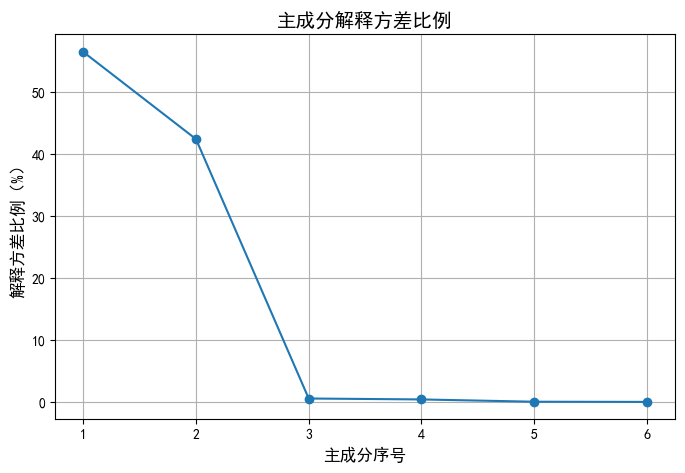

In [60]:
# 绘制各主成分的解释方差比例（以百分比形式展示）
plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    marker='o', linestyle='-'
)
plt.title('主成分解释方差比例', fontsize=14)
plt.xlabel('主成分序号', fontsize=12)
plt.ylabel('解释方差比例（%）', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.show()


## 绘制前两个主成分的 Biplot

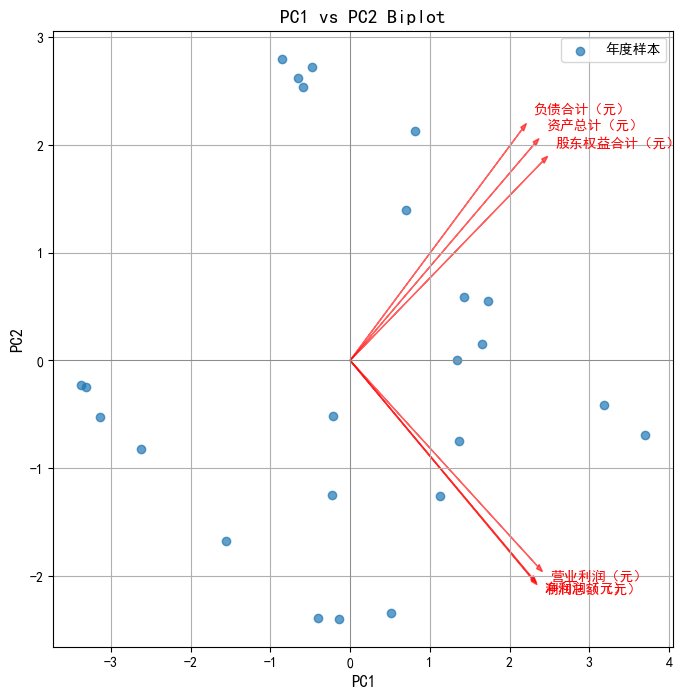

In [61]:
plt.figure(figsize=(8, 8))
# 样本投影点
plt.scatter(components[:, 0], components[:, 1], alpha=0.7, label='年度样本')
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

# 绘制每个指标在 PC1-PC2 上的载荷向量
for i, col in enumerate(numeric_cols):
    plt.arrow(
        0, 0,
        loadings_df.loc[col, 'PC1'] * 3,
        loadings_df.loc[col, 'PC2'] * 3,
        color='r', alpha=0.6, head_width=0.05
    )
    plt.text(
        loadings_df.loc[col, 'PC1'] * 3.2,
        loadings_df.loc[col, 'PC2'] * 3.2,
        col, color='r'
    )

plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('PC1 vs PC2 Biplot', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


样本点投影：
设原始标准化矩阵为 $X$，主成分特征向量矩阵为 $V$，则第 $i$ 年在第 $k$ 个主成分上的得分为：
$$z_{i,k}=\sum\limits_{j=1}^{6}\tilde{x}_{i,j}v_{j,k}$$
也可写作矩阵乘法 $Z = X_{\text{scaled}} V$。

在 Biplot 中，横纵坐标分别绘制每年在 PC1 和 PC2 上的得分值 $(z_{i,1},z_{i,2})$

样本点的聚类或分散能反映各年份在“综合实力因子”与“资本盈利因子”上的相似性与差异性。

指标载荷向量：
每个指标 $j$ 在主成分 $k$ 上的载荷为：
$$\ell_{j,k} = v_{j,k}\sqrt{\lambda_k}$$

其中，$v_{j,k}$ 为第 $j$ 个原始变量和第 $k$ 个主成分的相关系数，无量纲；$\sqrt{\lambda_k}$ 则调整了规模，使载荷具有可比较性。

本例中，在绘图时将 $(\ell_{j,1},,\ell_{j,2})$ 坐标放大了 3 倍 (* 3) 以便更清晰地展示。箭头起点均为原点 $(0,0)$。

若某指标箭头与 PC1 正方向近似平行，说明该指标与 PC1 高度正相关；若箭头与 PC2 反方向近似（指向右下），则说明该指标在 PC2 上为负载荷，二者呈负相关。

从图中可以观察到：

“股东权益合计”（行列式载荷最大）与“资产总计”、“营业利润” 的箭头均几乎指向 PC1 的正方向，表明这三个指标对第一个主成分（即“综合实力因子”）的贡献最大。

在 PC2 维度上，

“资产总计”与“负债合计”位于 PC2 的正半轴（箭头向右上），说明这两项指标跟“资本结构扩张”正相关。

“营业利润”、“利润总额”“净利润”位于 PC2 的负半轴（箭头向右下），说明盈利指标跟资本结构（负债、规模扩张）在短期存在一定冲突：

若负债大幅增加，短期内可能压缩盈利(盈利指标在 PC2 上得分为负)
 
样本点投影 分布形状：

若某一年样本在 Biplot 上靠近“股东权益合计”“资产总计”箭头端点方向，则说明该年企业资产与股东权益都较高，综合实力强。

若某一年样本在 PC2 负方向明显，则表示该年盈利性相对突出，但可能伴随较低的资产负债扩张速度。

